# Import Dependencies

In [89]:
import sys
sys.path.append("../code-python3")
from linear_algebra import squared_distance, vector_mean, distance, get_column
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# k-means Model

In [90]:
class KMeans:
    """performs k-means clustering"""

    def __init__(self, k):
        self.k = k          # number of clusters
        self.means = None   # means of clusters

    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs):

        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # Find new assignments
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, we're done.
            if assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = vector_mean(i_points)
                    


In [91]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(0) # so you get the same results as me
clusterer = KMeans(3)
clusterer.train(inputs)
print("3-means:")
print(clusterer.means)
print()

3-means:
[[-25.857142857142854, -4.714285714285714], [20.0, 26.0], [16.666666666666664, 13.666666666666666]]



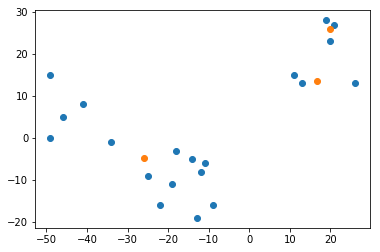

In [60]:
plt.scatter(get_column(inputs, 0), get_column(inputs, 1))
plt.scatter(get_column(clusterer.means, 0), get_column(clusterer.means, 1))
plt.show()

In [61]:
random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
print("2-means:")
print(clusterer.means)
print()

2-means:
[[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]



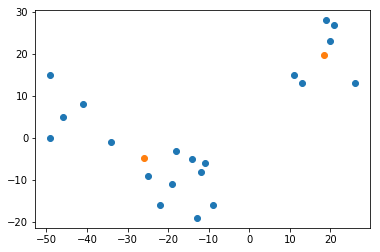

In [62]:
plt.scatter(get_column(inputs, 0), get_column(inputs, 1))
plt.scatter(get_column(clusterer.means, 0), get_column(clusterer.means, 1))
plt.show()

# Choosing k

In [92]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))

    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))

def plot_squared_clustering_errors():

    ks = range(1, len(inputs) + 1)
    errors = [squared_clustering_errors(inputs, k) for k in ks]

    plt.plot(ks, errors)
    plt.xticks(ks)
    plt.xlabel("k")
    plt.ylabel("total squared error")
    plt.show()


In [93]:
print("errors as a function of k")

for k in range(1, len(inputs) + 1):
    print(k, squared_clustering_errors(inputs, k))
print()

errors as a function of k
1 15241.35
2 4508.738095238095
3 1209.0555555555557
4 1060.0555555555557
5 1037.8055555555557
6 797.1666666666667
7 475.1666666666667
8 676.0
9 417.0
10 245.75
11 255.66666666666666
12 135.58333333333334
13 199.25
14 123.0
15 50.5
16 42.0
17 42.5
18 22.5
19 2.5
20 0.0



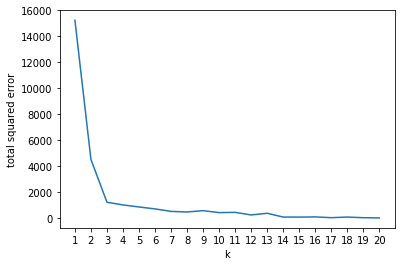

In [94]:
plot_squared_clustering_errors()

# Example: Clustering Colors

Original Image


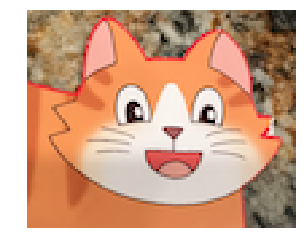

New Image


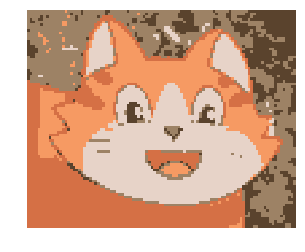

In [95]:
#
# using clustering to recolor an image
#

def recolor_image(input_file, k=5):

    img = mpimg.imread(input_file)
    print("Original Image")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    pixels = [pixel for row in img for pixel in row]
    clusterer = KMeans(k)
    clusterer.train(pixels) # this might take a while

    def recolor(pixel):
        cluster = clusterer.classify(pixel) # index of the closest cluster
        return clusterer.means[cluster]     # mean of the closest cluster

    new_img = [[recolor(pixel) for pixel in row]
               for row in img]

    print("New Image")
    plt.imshow(new_img)
    plt.axis('off')
    plt.show()
    
recolor_image(r"../data/image.png")

# Bottom-up Hierarchical Clustering

In [96]:
leaf1 = ([10, 20],)
leaf2 = ([30, -15],)
print(leaf1)
print(leaf2)

([10, 20],)
([30, -15],)


In [97]:
merged = (1, [leaf1, leaf2])

In [98]:
print(merged)

(1, [([10, 20],), ([30, -15],)])


In [99]:
#
# hierarchical clustering
#

def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

def get_children(cluster):
    """returns the two children of this cluster if it's a merged cluster;
    raises an exception if this is a leaf cluster"""
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster # is already a 1-tuple containing value
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

In [100]:
get_values(leaf1)

([10, 20],)

In [101]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """finds the aggregate distance between elements of cluster1
    and elements of cluster2"""
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0] # merge_order is first element of 2-tuple

def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters


In [103]:
print("bottom up hierarchical clustering")

base_cluster = bottom_up_cluster(inputs)
print(base_cluster)

print()
print("three clusters, min:")
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))

print()
print("three clusters, max:")
base_cluster = bottom_up_cluster(inputs, max)
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))
    


bottom up hierarchical clustering
(0, [(1, [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]), (16, [([11, 15],), ([13, 13],)])]), (2, [(4, [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]), ([-34, -1],)]), (6, [(7, [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]), (13, [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]), ([-18, -3],)])]), (12, [([-13, -19],), ([-9, -16],)])])])])

three clusters, min:
[[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]]
[[19, 28], [21, 27], [20, 23], [26, 13]]
[[11, 15], [13, 13]]

three clusters, max:
[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]]
[[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]]
[[-11, -6], [-12, -8], [-14, -5], [-18, -3], [-22, -16], [-19, -11], [-25, -9], [-13, -19], [-9, -16]]


In [109]:
three_clusters = [get_values(cluster) 
                  for cluster in generate_clusters(base_cluster, 3)]

In [110]:
three_clusters

[[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]],
 [[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]],
 [[-11, -6],
  [-12, -8],
  [-14, -5],
  [-18, -3],
  [-22, -16],
  [-19, -11],
  [-25, -9],
  [-13, -19],
  [-9, -16]]]

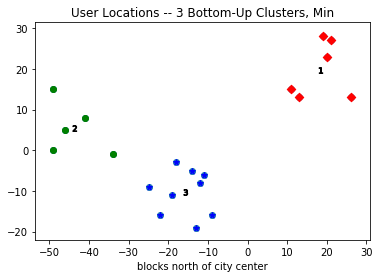

In [112]:
for i, cluster, marker, color in zip([1, 2, 3],
                                    three_clusters,
                                    ['D', 'o', '*'],
                                    ['r', 'g', 'b']):
    xs, ys = zip(*cluster) # magic unzipping trick
    plt.scatter(xs, ys, color=color, marker= marker)
    
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$' + str(i) + '$', color='black')
    
plt.title("User Locations -- 3 Bottom-Up Clusters, Min")
plt.xlabel("blocks east of city center")
plt.xlabel("blocks north of city center")
plt.show()